### Keras Tuner

        Código

#### Librerías

In [ ]:
pip install keras-tuner

In [15]:
from kerastuner import HyperModel
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten, MaxPooling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose, DepthwiseConv2D
import sys, os, zipfile, glob, cv2
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import h5py, keras
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adagrad, Adam

Mounted at /content/drive


Antes de comenzar la búsqueda, preparemos el conjunto de datos 

#### Base de datos

In [16]:
path_h5 = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/'

In [17]:
!wget --no-check-certificate \
   https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0\
   -O cats_and_dogs_small.zip

local_zip = 'cats_and_dogs_small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

--2022-03-28 03:04:22--  https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip [following]
--2022-03-28 03:04:22--  https://www.dropbox.com/s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5f3a427ea77ff4e5b44dee60f.dl.dropboxusercontent.com/cd/0/inline/BiQTFTRuelVZOCILrQ1kHqouw0WiAcU7hZmri4nUIm7r2c9m2D24Ks1N2u7ngzaqY2FiCmDNgIzFBq9wyiHtDPu3ZDeQ24rDQqjQjViJHvF8EzlhdcTQ4NhS09LgQuv1uegRSwScBrTyBbhISiYzoGG9MxP5yVKOeIy4bLRWvILLGg/file# [following]
--2022-03-28 03:04:23--  https://uce5f3a427ea77ff4e5b44dee60f.dl.dropboxusercontent.com/cd/0/inline/BiQTFTRuelVZOCILrQ1kHqouw0W

#### Pre procesamiento

In [18]:
# Lectura de imagenes
categorias = ['cats', 'dogs']
X = []
Y = []
for categoria in tqdm(categorias):  
  ruta_imgs = glob.glob('./cats_and_dogs_small/'+ categoria +'/*.jpg')
  for ruta_img in ruta_imgs:
    img = cv2.resize(cv2.imread(ruta_img), (150, 150))
    X.append(img)
    if categoria == 'cats':
      Y.append(0)
    else:
      Y.append(1)

# Asignacion de variables X e Y
X = np.asarray(X).astype('uint8')
Y = np.expand_dims(np.asarray(Y).astype('uint8'),axis =1)
#print(type(X[0,0,0,0]), X.shape)
#print(type(Y[0,0]), Y.shape)
#print(len(X))
#print(len(Y))
#print(Y)

# Aleatorizar variables
X,Y = shuffle(X,Y)
#print(Y)

# Escritura y lectura de archivo HDF5
with h5py.File(path_h5 + 'dataset_cat_dogs.hdf5', 'w') as hf:
    x = hf.create_dataset('X', data = X, shape = X.shape, compression = 'gzip', compression_opts = 9,chunks = True)
    y = hf.create_dataset('Y', data = Y, shape = Y.shape, compression = 'gzip', compression_opts = 9,chunks = True)

with h5py.File(path_h5 + 'dataset_cat_dogs.hdf5', 'r') as hf:
    X = hf['X'][:]
    Y = hf['Y'][:]
#print('Conjunto de datos en X:',X.shape)
#print('Conjunto de datos en Y:',Y.shape)

# Normalizacion
X=X.astype('float32')
X/=255.0
#Y = to_categorical(Y)

# Regla 60/20/20
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.75)
#print( x_train.shape, x_val.shape, x_test.shape)
#print( y_train.shape, y_val.shape, y_test.shape)

100%|██████████| 2/2 [00:14<00:00,  7.08s/it]


#### Hipermodelo

In [19]:
class MiHiperModelo(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        
        kernel_size1 = hp.Choice('kernel_size1', values=[3,5,7]) 
        strides1 = hp.Choice('strides1', values=[1, 2]) 
        pool_size1 = hp.Choice('pool_size1', values=[2, 4]) 
        #kernel_size2 = hp.Choice('kernel_size2', values=[1, 2, 3]) 
        #pool_size2 = hp.Choice('strides1', values=[2, 3, 4]) 


        model.add(Conv2D(filters=hp.Int('filters1',
                                        min_value=32,
                                        max_value=1024,
                                        step=32,
                                        default=1024),
                                        kernel_size = (kernel_size1, kernel_size1), 
                                        strides = (strides1, strides1),
                                        padding = 'valid',  
                                        activation=hp.Choice('activation', values=['relu', 'tanh']) ))

        model.add(Conv2D(filters=hp.Int('filters2',
                                        min_value=64,
                                        max_value=512,
                                        step=64,
                                        default=512),
                                        kernel_size = (kernel_size1, kernel_size1), 
                                        strides = (strides1, strides1),   
                                        padding = 'valid',  
                                        activation=hp.Choice('activation', values=['relu', 'tanh']) ))


        model.add(MaxPooling2D( pool_size=(pool_size1, pool_size1)))    

        model.add(Dropout(0.5))

        model.add(Flatten())

        model.add(Dropout(0.5))

        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=Adam(
                hp.Choice('learning_rate',
                          values=[ 1e-4])),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        
        
        return model


Para inicializar el sintonizador, necesitamos especificar varios argumentos en el inicializador.


In [20]:
hypermodel = MiHiperModelo(num_classes=2)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5, #representa la cantidad de combinaciones de hiperparámetros que probará el sintonizador
    executions_per_trial = 1, #cantidad de modelos que se deben construir y ajustar para cada prueba con fines de robustez.
    directory='my_dir',
    project_name='helloworld6')

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project my_dir/helloworld6/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/helloworld6/tuner0.json
Search space summary
Default search space size: 7
kernel_size1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
strides1 (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
pool_size1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 4], 'ordered': True}
filters1 (Int)
{'default': 1024, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
filters2 (Int)
{'default': 512, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001], 'ordered': True}


Puede imprimir un resumen del espacio de búsqueda:


In [21]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld6
Showing 10 best trials
Trial summary
Hyperparameters:
kernel_size1: 3
strides1: 1
pool_size1: 2
filters1: 192
activation: relu
filters2: 256
learning_rate: 0.0001
Score: 0.7350000143051147
Trial summary
Hyperparameters:
kernel_size1: 3
strides1: 1
pool_size1: 4
filters1: 288
activation: tanh
filters2: 256
learning_rate: 0.0001
Score: 0.7275000214576721
Trial summary
Hyperparameters:
kernel_size1: 3
strides1: 1
pool_size1: 4
filters1: 416
activation: tanh
filters2: 128
learning_rate: 0.0001
Score: 0.7137500047683716
Trial summary
Hyperparameters:
kernel_size1: 3
strides1: 2
pool_size1: 4
filters1: 704
activation: tanh
filters2: 384
learning_rate: 0.0001
Score: 0.7049999833106995
Trial summary
Hyperparameters:
kernel_size1: 7
strides1: 1
pool_size1: 4
filters1: 480
activation: tanh
filters2: 384
learning_rate: 0.0001
Score: 0.6987500190734863
Trial summary
Hyperparameters:
kernel_size1: 7
strides1: 1
pool_size1: 4
filters1: 800
activation: ta

#### Búsqueda

inicie la búsqueda de la mejor configuración de hiperparámetros

In [22]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

INFO:tensorflow:Oracle triggered exit


Durante el search, la función de creación de modelos se llama con diferentes valores de hiperparámetro en diferentes pruebas. En cada prueba, el sintonizador generaría un nuevo conjunto de valores de hiperparámetros para construir el modelo. Luego se ajusta y evalúa el modelo. Las métricas se registran. El sintonizador explora progresivamente el espacio y finalmente encuentra un buen conjunto de valores de hiperparámetros.



In [23]:
best_model = tuner.get_best_models(num_models=1)[0]

In [24]:
best_model.build((None, 150, 150,3))

También puede imprimir un resumen de los resultados de la búsqueda.



In [25]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 192)     5376      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 256)     442624    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 256)       0         
                                                                 
 flatten (Flatten)           (None, 1364224)           0         
                                                                 
 dropout_1 (Dropout)         (None, 1364224)           0         
                                                        

In [26]:
loss, accuracy = best_model.evaluate(x_test, y_test)

25/25 [==============================] - 2s 60ms/step - loss: 0.3169 - accuracy: 0.8800


In [27]:
y_pred = np.argmax(best_model.predict(x_test), axis=1)

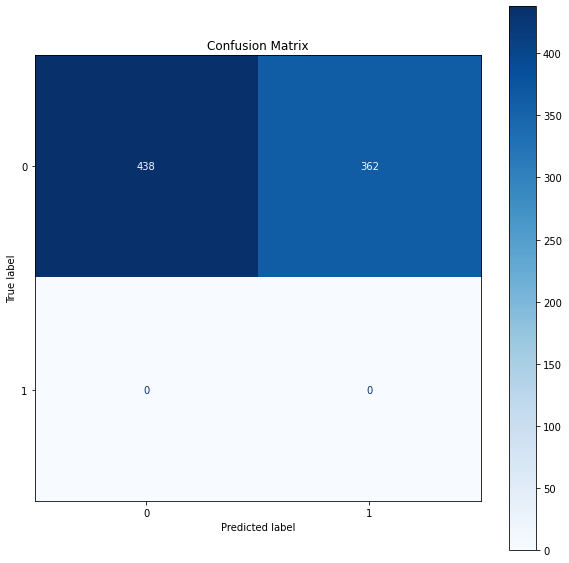

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.show()

In [29]:
reporte = classification_report(np.argmax(y_test, axis=1), y_pred,target_names = categorias)
print(reporte)

              precision    recall  f1-score   support

        cats       1.00      0.55      0.71       800
        dogs       0.00      0.00      0.00         0

    accuracy                           0.55       800
   macro avg       0.50      0.27      0.35       800
weighted avg       1.00      0.55      0.71       800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Referencias

DigitalSreeni (s.f) Trucos de consejos 20: comprensión del aprendizaje de transferencia para diferentes tamaños y entradas de canal. Recuperado el día 26 de Marzo de 2022 de https://www.youtube.com/watch?v=5kbpoIQUB4Q

fchollet(2021) simple MNIST convnet. Recuperado el día 26 de Marzo de 2022 de https://keras.io/examples/vision/mnist_convnet/

Hebbar, N. (2020) Keras Tuner Hyperparameter Tuning for Neural Networks in Minutes. Recuperado el 27 de Marzo de 2022 de https://www.youtube.com/watch?v=Clo1HKB50Ug

Jin, H (2021) Visualice el proceso de ajuste de hiperparámetros. Recuperado el día 26 de Marzo de 2022 de https://keras.io/guides/keras_tuner/visualize_tuning/

sentdex (2019) Optimización de estructuras de redes neuronales con Keras-Tuner. Recuperado el 26 de Marzo de 2022 de https://www.youtube.com/watch?v=vvC15l4CY1Q